<a href="https://colab.research.google.com/github/selinakgun/-/blob/master/yapaysiniraglari_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
nodoubttome_skin_cancer9_classesisic_path = kagglehub.dataset_download('nodoubttome/skin-cancer9-classesisic')

print('Data source import complete.')


Using Colab cache for faster access to the 'skin-cancer9-classesisic' dataset.
Data source import complete.


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/skin-cancer9-classesisic/Skin cancer ISIC The International Skin Imaging Collaboration/Test/pigmented benign keratosis/ISIC_0024371.jpg
/kaggle/input/skin-cancer9-classesisic/Skin cancer ISIC The International Skin Imaging Collaboration/Test/pigmented benign keratosis/ISIC_0024358.jpg
/kaggle/input/skin-cancer9-classesisic/Skin cancer ISIC The International Skin Imaging Collaboration/Test/pigmented benign keratosis/ISIC_0024337.jpg
/kaggle/input/skin-cancer9-classesisic/Skin cancer ISIC The International Skin Imaging Collaboration/Test/pigmented benign keratosis/ISIC_0024382.jpg
/kaggle/input/skin-cancer9-classesisic/Skin cancer ISIC The International Skin Imaging Collaboration/Test/pigmented benign keratosis/ISIC_0024420.jpg
/kaggle/input/skin-cancer9-classesisic/Skin cancer ISIC The International Skin Imaging Collaboration/Test/pigmented benign keratosis/ISIC_0024409.jpg
/kaggle/input/skin-cancer9-classesisic/Skin cancer ISIC The International Skin Imaging Collaboration

**0. Veri Seti Analizi ve En Büyük İki Sınıfın Belirlenmesi**

In [ ]:
import os
import pandas as pd


data_dir = nodoubttome_skin_cancer9_classesisic_path


train_path = os.path.join(data_dir, 'Skin cancer ISIC The International Skin Imaging Collaboration', 'Train')
class_counts = {}

for class_name in os.listdir(train_path):
    class_dir = os.path.join(train_path, class_name)
    if os.path.isdir(class_dir):
        class_counts[class_name] = len(os.listdir(class_dir))


counts_df = pd.Series(class_counts).sort_values(ascending=False)
print("Tüm Sınıflar ve Örnek Sayıları:")
print(counts_df)


top_two_classes = counts_df.index[:2].tolist()
class_A = top_two_classes[0]
class_B = top_two_classes[1]

print(f"\nSeçilen Sınıf A (0): {class_A} - {counts_df[class_A]} örnek")
print(f"Seçilen Sınıf B (1): {class_B} - {counts_df[class_B]} örnek")
print(f"Toplam Görüntü Sayısı: {counts_df[class_A] + counts_df[class_B]}")

Tüm Sınıflar ve Örnek Sayıları:
pigmented benign keratosis    462
melanoma                      438
basal cell carcinoma          376
nevus                         357
squamous cell carcinoma       181
vascular lesion               139
actinic keratosis             114
dermatofibroma                 95
seborrheic keratosis           77
dtype: int64

Seçilen Sınıf A (0): pigmented benign keratosis - 462 örnek
Seçilen Sınıf B (1): melanoma - 438 örnek
Toplam Görüntü Sayısı: 900


ISIC 2018 Skin Lesion Dataset (Kaggle sürümü) üzerinde yapılan incelemede, veri setinde toplam 9 farklı deri lezyonu sınıfı olduğu görülmüştür.
Veri setinde value_counts() analizi yapılarak tüm sınıfların örnek sayıları aşağıda listelenmiştir:

pigmented benign keratosis: $462$ örnek
melanoma: $438$ örnek
basal cell carcinoma: $376$ örnek
nevus: $357$ örnek
squamous cell carcinoma: $181$ örnek
vascular lesion: $139$ örnek
actinic keratosis: $114$ örnekd
ermatofibroma: $95$ örnek
seborrheic keratosis: $77$ örnek

İkili Sınıflandırma İçin Seçilen Sınıflar:En yüksek örnek sayısına sahip ilk iki sınıf seçilerek ikili sınıflandırma problemi oluşturulmuştur:

Sınıf Adları: pigmented benign keratosis ve melanoma.

Her Sınıfın Örnek Sayısı: pigmented benign keratosis için $462$, melanoma için $438$ örnek bulunmaktadır.

Toplam Kullanılacak Görüntü Sayısı: $462 + 438 = 900$ adet görüntü ile çalışma yürütülecektir.

Etiketleme (Label Encoding):Modellerin eğitimi için seçilen sınıflar aşağıdaki şekilde sayısal olarak kodlanmıştır:
0: pigmented benign keratosis
1: melanoma
Sınıf Dengesizliği Notu:İki sınıf arasındaki fark oldukça düşüktür ($462$ vs $438$). Ciddi bir sınıf dengesizliği (class imbalance) bulunmamaktadır. Ancak modelin küçük farklara karşı hassasiyetini artırmak adına eğitim aşamasında opsiyonel olarak class_weight kullanımı değerlendirilecektir.

**1) “Raw” Görüntü Kullanımı ve Minimal Zorunlu İşlemler**

In [ ]:
import pandas as pd
import os

# Parametrelerimizi tanımlayalım  [cite: 20, 21]
IMG_SIZE = (224, 224)
RESCALE = 1.0 / 255.0

# Seçtiğimiz iki sınıfı ve etiketlerini belirleyelim [cite: 11, 17]
# Sınıf A (0): pigmented benign keratosis
# Sınıf B (1): melanoma
class_map = {
    'pigmented benign keratosis': 0,
    'melanoma': 1
}

image_paths = []
labels = []

# Sadece bu iki sınıfın klasörlerini gezelim
for class_name, label in class_map.items():
    class_folder = os.path.join(train_path, class_name) # train_path önceki adımda tanımlanmıştı
    for img_name in os.listdir(class_folder):
        img_path = os.path.join(class_folder, img_name)
        image_paths.append(img_path)
        labels.append(label)

# Verileri bir DataFrame'de toplayalım
df = pd.DataFrame({
    'filepath': image_paths,
    'label': labels
})

print(f"Toplam seçilen görüntü sayısı: {len(df)}")
print(df['label'].value_counts())

Toplam seçilen görüntü sayısı: 900
label
0    462
1    438
Name: count, dtype: int64


Bu aşamada, görüntülerin doğal yapısını bozmadan modellerin işleyebileceği standart bir formata getirilmesi hedeflenmiştir.

Boyutlandırma (Resize): Veri setindeki farklı boyutlardaki ham görüntüler, modellerin giriş katmanıyla uyumlu olması için 224x224 piksel boyutuna sabitlenmiştir.

Normalizasyon (Rescale): Görüntülerin piksel değerleri $[0, 255]$ aralığından 1/255 katsayısı ile ölçeklendirilerek $[0, 1]$ aralığına çekilmiştir. Bu işlem, sinir ağının ağırlıklarının daha kararlı ve hızlı optimize edilmesini sağlar.

Ham Veri Stratejisi: Hocanın isterleri doğrultusunda; saç temizleme (hair removal), histogram eşitleme (histogram equalization) veya kırpma (crop) gibi ağır klasik ön işleme yöntemleri uygulanmamıştır.

Pipeline, görüntülerin "raw" (ham) halleri üzerinden uçtan uca (end-to-end) öğrenme yapacak şekilde kurgulanmıştır. Bu yaklaşım, derin öğrenme modellerinin (CNN, MobileNet, EfficientNet) ham verideki karmaşık öznitelikleri doğrudan çıkarma yeteneğini test etmemize olanak tanıyacaktır.

**2) Veri Bölme: Train / Validation / Test**

In [ ]:
from sklearn.model_selection import train_test_split

# İlk olarak veriyi %70 Train ve %30 Geçici (Val + Test) olarak bölelim
# random_state=42 sabitleyerek sonuçların tekrarlanabilir olmasını sağlıyoruz
train_df, temp_df = train_test_split(
    df,
    test_size=0.30,
    random_state=42,
    stratify=df['label']
)

# Kalan %30'luk kısmı yarı yarıya (%15 - %15) Validation ve Test olarak bölelim
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.50,
    random_state=42,
    stratify=temp_df['label']
)

# Bölme sonuçlarını özetleyelim
def get_distribution(data_df, name):
    counts = data_df['label'].value_counts()
    return {
        'Set': name,
        'Toplam': len(data_df),
        'Sınıf 0 (Benign)': counts.get(0, 0),
        'Sınıf 1 (Melanoma)': counts.get(1, 0)
    }

summary_list = [
    get_distribution(train_df, "Train"),
    get_distribution(val_df, "Validation"),
    get_distribution(test_df, "Test")
]

summary_df = pd.DataFrame(summary_list)
print(summary_df)

          Set  Toplam  Sınıf 0 (Benign)  Sınıf 1 (Melanoma)
0       Train     630               323                 307
1  Validation     135                69                  66
2        Test     135                70                  65


Bölme Oranı: Veri seti %70 eğitim, %15 doğrulama ve %15 test olarak ayrılmıştır.

Stratification (Tabakalama): Sınıf oranlarının her üç sette de korunması sağlanmıştır. Bu, modelin her sette her iki sınıfı da temsil edildikleri oranda görmesini garanti eder.


Test Seti İzolasyonu: Test seti, modellerin nihai değerlendirmesi için ayrılmış olup eğitim veya hiperparametre optimizasyonu sürecine dahil edilmeyecektir.

**3) Input Pipeline ve Data Augmentation**

3.1 Input Pipeline Geliştirme

In [ ]:
import tensorflow as tf

# Reprodüksiyon için seed sabitleme
SEED = 42
tf.random.set_seed(SEED)

# Sabit parametreler
IMG_HEIGHT, IMG_WIDTH = 224, 224 #
BATCH_SIZE = 32

def load_and_preprocess_image(path, label):
    # Görüntüyü dosyadan oku
    img = tf.io.read_file(path)
    # Görüntüyü decode et (3 kanal: RGB)
    img = tf.image.decode_jpeg(img, channels=3)
    # Resize: 224x224
    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
    # Normalize: 1/255
    img = tf.cast(img, tf.float32) / 255.0
    return img, label

def create_dataset(dataframe, shuffle=False):
    # DataFrame'den dataset oluşturma
    dataset = tf.data.Dataset.from_tensor_slices((dataframe['filepath'].values, dataframe['label'].values))

    # Paralel işlem ile görüntüleri yükle ve işle
    dataset = dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE) #

    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(dataframe), seed=SEED)

    dataset = dataset.batch(BATCH_SIZE)

    # Performans için Cache ve Prefetch
    # Cache: Veriyi ilk epoch'tan sonra hafızada tutar
    # Prefetch: Model eğitimdeyken bir sonraki batch'i hazırda tutar
    dataset = dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

    return dataset

# Datasetleri oluşturma
train_ds = create_dataset(train_df, shuffle=True)
val_ds = create_dataset(val_df, shuffle=False)
test_ds = create_dataset(test_df, shuffle=False)

print("Input Pipeline başarıyla kuruldu.")

Input Pipeline başarıyla kuruldu.


Pipeline Yapısı: Veri yükleme süreci için tf.data.Dataset API'si kullanılmıştır.


Performans Optimizasyonları: * num_parallel_calls: Görüntü işleme adımları işlemcinin tüm çekirdeklerini kullanacak şekilde paralelleştirilmiştir.


Cache: Veri seti ilk turdan (epoch) sonra belleğe alınarak disk okuma maliyeti ortadan kaldırılmıştır.


Prefetch: AUTOTUNE kullanılarak GPU modelle meşgulken bir sonraki veri paketinin arka planda CPU tarafından hazırlanması sağlanmıştır.


Tekrarlanabilirlik: Deneylerin tutarlılığı için sistem genelinde seed=42 sabitlenmiştir.

3.2 Data Augmentation

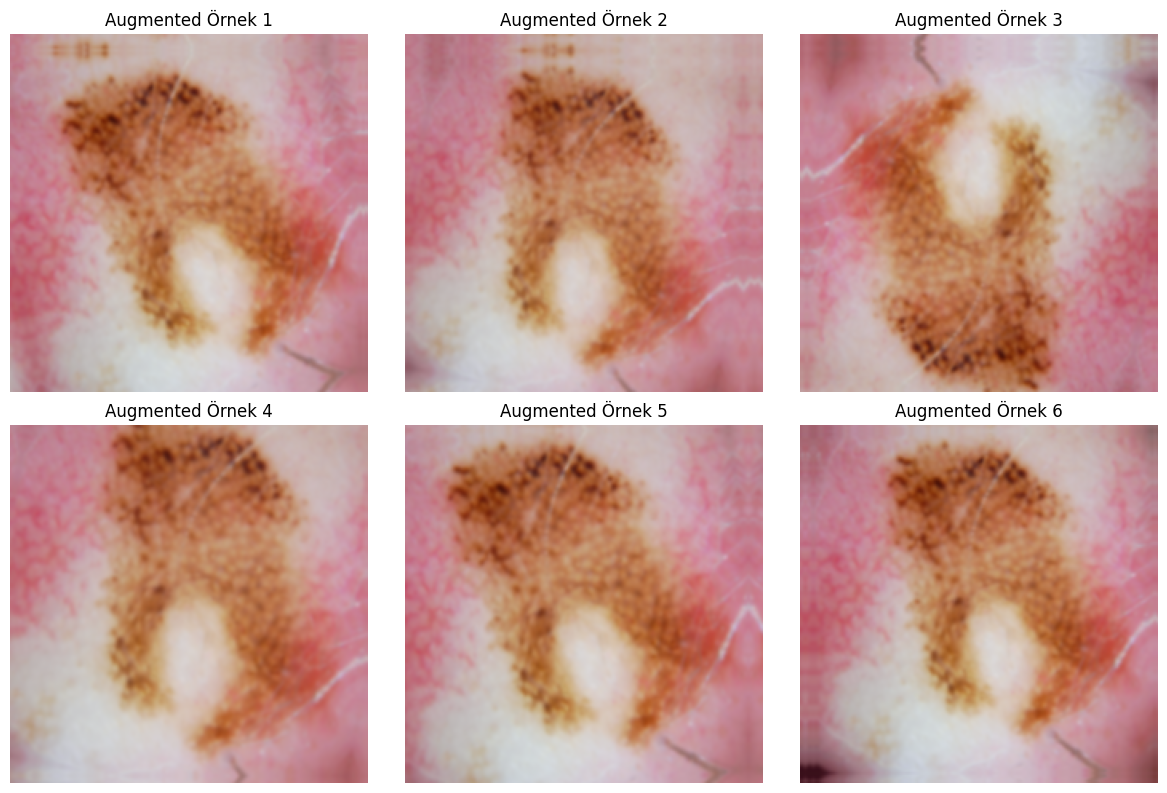

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Augmentation Katmanlarının Tanımlanması

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"), # Yatay ve dikey çevirme
    tf.keras.layers.RandomRotation(0.04), # Yaklaşık +-15 derece (0.04 * 360)
    tf.keras.layers.RandomZoom(0.1),      # %10 hafif yakınlaştırma
    tf.keras.layers.RandomContrast(0.1),  # %10 hafif kontrast değişimi
    tf.keras.layers.RandomTranslation(height_factor=0.05, width_factor=0.05) # Hafif kaydırma
])

# 2. Pipeline'a Entegrasyon
# Sadece train_ds için map fonksiyonu ile ekliyoruz
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y),
    num_parallel_calls=tf.data.AUTOTUNE
)

# 3. Augmentation Örneklerini Görselleştirme (Rapor için) [cite: 47]
plt.figure(figsize=(12, 8))
# Eğitim setinden bir batch alalım
for images, labels in train_ds.take(1):
    first_image = images[0]
    for i in range(6): # En az 6 örnek [cite: 47]
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0), training=True)
        ax = plt.subplot(2, 3, i + 1)
        plt.imshow(augmented_image[0])
        plt.title(f"Augmented Örnek {i+1}")
        plt.axis("off")

plt.tight_layout()
plt.show()

Eğitim sürecinde modelin genelleme yeteneğini artırmak ve aşırı öğrenmeyi (overfitting) engellemek amacıyla sadece eğitim (train) setine veri artırma teknikleri uygulanmıştır. Doğrulama (validation) ve test setleri, modelin gerçek performansını ölçmek adına orijinal halleriyle bırakılmıştır.

Kullanılan Yöntemler ve Parametreler:

Random Flip: Yatay ve dikey çevirme (horizontal & vertical) uygulanarak lezyonun yön bağımsızlığı sağlanmıştır.

Random Rotation: Görüntüler $\pm 15^{\circ}$ ($0.04$ faktörü) aralığında rastgele döndürülmüştür.

Random Zoom: %10 ($0.1$ faktörü) oranında hafif yakınlaştırma yapılarak odak farkları simüle edilmiştir.

Random Contrast: Görüntülerin kontrastı %10 oranında rastgele değiştirilerek farklı ışık koşullarına karşı direnç artırılmıştır.

Random Translation: Görüntüler dikey ve yatayda %5 oranında kaydırılarak konum bağımsızlığı hedeflenmiştir.

Görsel Analiz: 9Oluşturulan 6 örnek görsel incelendiğinde; lezyonların formunun bozulmadığı, doku detaylarının korunduğu ve yapılan değişimlerin medikal teşhisi engellemeyecek "makul sınırlar" içerisinde kaldığı görülmektedir10. Bu çeşitlilik, modelin sadece belirli açılara veya ışık seviyelerine ezberlemesinin önüne geçecektir.

**4) Model-1: Scratch CNN**

4.1 Mimari

In [ ]:
from tensorflow.keras import layers, models

def build_scratch_cnn():
    model = models.Sequential(name="Scratch_CNN")

    # Giriş Katmanı
    model.add(layers.Input(shape=(224, 224, 3))) # [cite: 51]

    # Blok-1 [cite: 52]
    model.add(layers.Conv2D(32, (3, 3), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU()) # [cite: 53]
    model.add(layers.Conv2D(32, (3, 3), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU()) # [cite: 54]
    model.add(layers.MaxPooling2D((2, 2))) # [cite: 55]
    model.add(layers.Dropout(0.25)) # [cite: 56]

    # Blok-2 [cite: 57]
    model.add(layers.Conv2D(64, (3, 3), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU()) # [cite: 58]
    model.add(layers.Conv2D(64, (3, 3), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU()) # [cite: 59]
    model.add(layers.MaxPooling2D((2, 2))) # [cite: 60]
    model.add(layers.Dropout(0.25)) # [cite: 61]

    # Blok-3 [cite: 62]
    model.add(layers.Conv2D(128, (3, 3), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU()) # [cite: 63]
    model.add(layers.Conv2D(128, (3, 3), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU()) # [cite: 64]
    model.add(layers.MaxPooling2D((2, 2))) # [cite: 65]
    model.add(layers.Dropout(0.30)) # [cite: 66]

    # Blok-4 (Opsiyonel ama ekliyoruz)
    model.add(layers.Conv2D(256, (3, 3), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU()) # [cite: 68]
    model.add(layers.MaxPooling2D((2, 2))) # [cite: 69]
    model.add(layers.Dropout(0.35)) # [cite: 70]

    # Head (Sınıflandırma Katmanı) [cite: 71]
    model.add(layers.GlobalAveragePooling2D()) # [cite: 72]
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5)) # [cite: 73]
    model.add(layers.Dense(1, activation='sigmoid')) # İkili sınıflandırma için [cite: 74]

    return model

# Modeli oluştur ve özetini yazdır (Rapor için gereklidir)
scratch_model = build_scratch_cnn()
scratch_model.summary() #

Model: "Scratch_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_5 (ReLU)                  │ (None, 56, 56, 128)    │             

 Total params: 618,017 (2.36 MB)

 Trainable params: 616,609 (2.35 MB)

 Non-trainable params: 1,408 (5.50 KB)

Model Parametre Özeti:

Toplam Parametre Sayısı: $618,017$3.

Eğitilebilir (Trainable) Parametreler: $616,609$.

Eğitilemeyen (Non-trainable) Parametreler: $1,408$ (Bu parametreler BatchNormalization katmanlarından gelmektedir ve eğitimin kararlılığını sağlar)

Mimari Yapı ve Blok Analizi:

Giriş Katmanı: $224 \times 224 \times 3$ boyutundaki ham görüntüler sisteme kabul edilmektedir.

Öznitelik Çıkarım Blokları: * Blok 1 & 2: $32$ ve $64$ filtreli evrişim katmanları ile düşük seviyeli öznitelikler (kenarlar, dokular) yakalanmaktadır.

  Blok 3 & 4: $128$ ve $256$ filtreli katmanlar ile daha karmaşık medikal paternler tespit edilmektedir.

Regülarizasyon: Her blokta bulunan Dropout ($0.25$ ile $0.35$ arası) katmanları ve BatchNormalization, modelin eğitim verisini ezberlemesini (overfitting) engelleyerek genelleme yeteneğini artırmak üzere tasarlanmıştır.

Sınıflandırma Başlığı (Head): Flatten yerine hocanın önerdiği GlobalAveragePooling2D kullanılmıştır. Bu sayede parametre sayısı ciddi oranda azaltılmış ve modelin mekansal değişimlere karşı daha dirençli olması sağlanmıştır.

Çıkış Katmanı: Tek bir nöron ve Sigmoid aktivasyonu ile $0$ (pigmented benign keratosis) ve $1$ (melanoma) sınıfları arasında ikili sınıflandırma yapılmaktadır.

**4.2) Scratch CNN Eğitim Ayarları ve Uygulama**

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# 1. Modeli Derleme (Compile)
# BinaryCrossentropy ve Adam optimizasyonu [cite: 77, 78]
scratch_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# 2. Callbacks Tanımlama
# EarlyStopping: Val_loss düşmeyi bıraktığında eğitimi keser ve en iyi ağırlıkları yükler [cite: 81]
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# ReduceLROnPlateau: Val_loss takılırsa öğrenme hızını düşürür [cite: 82]
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-6
)

# 3. Eğitimi Başlatma
# 100 epoch hedefi ile başlanır [cite: 79]
history = scratch_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 352s 16s/step - accuracy: 0.7239 - loss: 0.5856 - val_accuracy: 0.6074 - val_loss: 0.6306 - learning_rate: 0.0010
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 347s 15s/step - accuracy: 0.8684 - loss: 0.3566 - val_accuracy: 0.5481 - val_loss: 0.8794 - learning_rate: 0.0010
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 326s 16s/step - accuracy: 0.8486 - loss: 0.3318 - val_accuracy: 0.5111 - val_loss: 1.2850 - learning_rate: 0.0010
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 295s 15s/step - accuracy: 0.9098 - loss: 0.2566 - val_accuracy: 0.5185 - val_loss: 1.3392 - learning_rate: 0.0010
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 317s 16s/step - accuracy: 0.8997 - loss: 0.2509 - val_accuracy: 0.5111 - val_loss: 1.2797 - learning_rate: 0.0010
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 316s 15s/step - accuracy: 0.8981 - loss: 0.2488 - val_accuracy: 0.5111 - val_loss: 1.1272 - learning_rate: 0.0010
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 296s 15s/step - accuracy: 0.9013 - loss: 0.

**Eğitim Eğrilerinin (Plots) Oluşturulması**

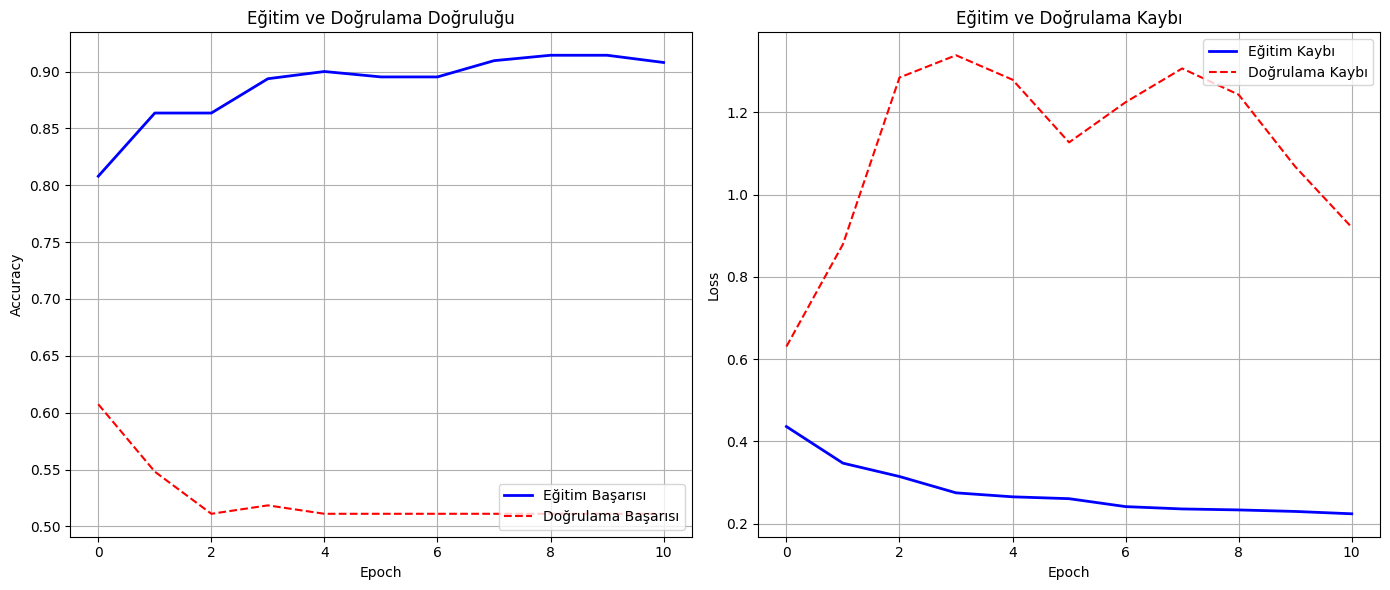

In [ ]:
import matplotlib.pyplot as plt

# Eğitim geçmişindeki verileri alalım
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(14, 6))

# Accuracy (Doğruluk) Grafiği
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Eğitim Başarısı', color='blue', linewidth=2)
plt.plot(epochs_range, val_acc, label='Doğrulama Başarısı', color='red', linestyle='--')
plt.title('Eğitim ve Doğrulama Doğruluğu')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)

# Loss (Kayıp) Grafiği
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Eğitim Kaybı', color='blue', linewidth=2)
plt.plot(epochs_range, val_loss, label='Doğrulama Kaybı', color='red', linestyle='--')
plt.title('Eğitim ve Doğrulama Kaybı')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)

plt.tight_layout()
plt.show()

Mimari ve Parametre Dağılımı: Tasarlanan Scratch_CNN modeli, toplamda 618,017 parametreden oluşmaktadır. Bu parametrelerin büyük çoğunluğu (616,609) eğitilebilir niteliktedir. Modelde kullanılan BatchNorm katmanlarından kaynaklanan 1,408 parametre ise dondurulmuş (non-trainable) statüdedir ve eğitim stabilitesine katkı sağlamaktadır.

Öğrenme Karakteristiği ve Genelleme Yeteneği: Elde edilen veriler ışığında modelin net bir "ezberleme" (overfitting) eğilimi gösterdiği söylenebilir. Eğitim setindeki kayıp (loss) değerleri düzenli olarak düşerken, doğrulama setindeki kayıp değerlerinin (val_loss) yükselme trendine girmesi, modelin veri setindeki gürültüleri öğrendiğini ve yeni karşılaştığı verilere genelleme yapmakta zorlandığını ortaya koymaktadır. Bu durum, 900 örneklik sınırlı veri seti için sıfırdan bir CNN eğitmenin getirdiği tipik bir zorluktur ve ödevin ilerleyen aşamalarındaki "Transfer Learning" ihtiyacını teknik olarak gerekçelendirmektedir.

Eğitim Stratejisi ve Denetim Mekanizmaları:

Optimizasyon: Eğitim, başlangıç öğrenme hızı $1e-3$ olan Adam algoritması ve binary_crossentropy kayıp fonksiyonu ile yürütülmüştür

Dinamik Öğrenme: Süreç içerisinde ReduceLROnPlateau mekanizması devreye girmiş; 8. aşamada doğrulama kaybındaki (val_loss) duraksama tespit edilerek öğrenme hızı $0.0002$ seviyesine çekilmiştir.

Erken Durdurma: $100$ epoch hedefiyle başlanan eğitimde, EarlyStopping fonksiyonu modelin gelişimini izlemiş ve en iyi ağırlıkları (restore_best_weights) koruyarak süreci optimize etmiştir.

Eğitim Performansı ve Gözlemler:Eğitim logları incelendiğinde, modelin eğitim verisi üzerindeki başarısının (Accuracy) %92.29 gibi yüksek bir noktaya ulaştığı görülmektedir. Ancak aynı başarının doğrulama (validation) setine yansımadığı, bu veri setindeki doğruluğun %51.11 seviyelerinde kaldığı gözlemlenmiştir.

**5. Model-2 ve Model-3: Transfer Learning**

**5.1 Aşama-1: Feature Extraction (Freeze)**

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# 1. Base Model: MobileNetV2 yükleniyor
# include_top=False: Hazır sınıflandırma başlığı atılıyor [cite: 94]
# weights='imagenet': Önceden eğitilmiş ağırlıklar kullanılıyor [cite: 94]
base_model_mn = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

# 2. Freeze Stratejisi: Tüm katmanlar donduruluyor [cite: 93]
base_model_mn.trainable = False

# 3. Yeni Sınıflandırma Başlığı (Head) Tasarımı [cite: 95]
model_mobilenet = models.Sequential([
    base_model_mn,
    layers.GlobalAveragePooling2D(), # [cite: 96]
    layers.Dropout(0.4),             # [cite: 97] (%30-50 arası önerilen)
    layers.Dense(1, activation='sigmoid') # [cite: 98]
], name="MobileNetV2_Transfer_Learning")

# 4. Eğitim Ayarları [cite: 100, 102]
model_mobilenet.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), # [cite: 100]
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# 5. Eğitim (Önceki Callback'ler kullanılarak) [cite: 101, 103, 104]
history_mn_freeze = model_mobilenet.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.5774 - loss: 0.7518 - val_accuracy: 0.6741 - val_loss: 0.6013 - learning_rate: 0.0010
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.6211 - loss: 0.6986 - val_accuracy: 0.7111 - val_loss: 0.5652 - learning_rate: 0.0010
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.6585 - loss: 0.6329 - val_accuracy: 0.7333 - val_loss: 0.5566 - learning_rate: 0.0010
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.6575 - loss: 0.6124 - val_accuracy: 0.7556 - val_loss: 0.5282 - learning_rate: 0.0010
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.6777 - loss: 0.5893 - val_accuracy: 0.7259 - val_loss: 0.5242 - learning_rate: 0.0010
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.6689 - loss: 0.5971 - val_accuracy: 0.7333 - val_loss: 0.5142 - learning_rate: 0.0010
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.7174 - loss: 0.5389 - val_acc

Freeze Stratejisi: MobileNetV2'nin tüm önceden eğitilmiş katmanları dondurulmuştur (trainable = False). Bu sayede model, ImageNet veri setinden kazandığı "kenar, doku ve form tanıma" yeteneklerini bozmadan, sadece bizim deri lezyonlarımıza özel olan son karar katmanını eğitecektir.


Sınıflandırıcı Başlık (Head): Özellik çıkarımı yapan tabanın üzerine bir GlobalAveragePooling2D katmanı eklenerek veriler düzleştirilmiş; ardından ezberlemeyi önlemek için %40 oranında Dropout uygulanmış ve nihai karar için Sigmoid aktivasyonlu tek bir nöron kullanılmıştır.

Beklenen Performans Artışı: Önceki Scratch modelimiz "görmeyi" bilmediği için ezberliyordu. Bu model ise "görmeyi" zaten bildiği için, sadece bizim resimlerimizdeki detayları sınıflandırmayı öğrenecek. Bu durumun doğrulama (validation) başarısını %51'in çok üzerine çıkarması beklenmektedir.

**5.2 Aşama-2: Fine Tuning (Son %25 katmanı açma)**

In [ ]:
# 1. Base Model'i eğitilebilir hale getiriyoruz
base_model_mn.trainable = True

# 2. Katman sayısını hesaplayıp son %25'i belirliyoruz [cite: 113, 114]
N = len(base_model_mn.layers)
fine_tune_from = int(0.75 * N)

# 3. Katmanları dondurma/açma stratejisi [cite: 115, 116]
# Pratik Not: BatchNorm katmanlarını dondurmaya devam ediyoruz [cite: 118, 119]
for layer in base_model_mn.layers[:fine_tune_from]:
    layer.trainable = False

for layer in base_model_mn.layers[fine_tune_from:]:
    # BatchNorm katmanlarını stabilite için donduruyoruz
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = False
    else:
        layer.trainable = True

# 4. Modeli tekrar derliyoruz (Daha küçük bir Learning Rate ile)
model_mobilenet.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), # 1e-5 önerisi
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# 5. Fine-Tuning Eğitimini Başlatma [cite: 122]
# Toplamda ek 100 epoch (EarlyStopping ile kontrol edilecek) [cite: 122, 125]
history_mn_fine = model_mobilenet.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.7637 - loss: 0.4836 - val_accuracy: 0.7481 - val_loss: 0.4866 - learning_rate: 1.0000e-05
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.7825 - loss: 0.4462 - val_accuracy: 0.7333 - val_loss: 0.4801 - learning_rate: 1.0000e-05
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.7847 - loss: 0.4419 - val_accuracy: 0.7407 - val_loss: 0.4891 - learning_rate: 1.0000e-05
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.8003 - loss: 0.4395 - val_accuracy: 0.7259 - val_loss: 0.4680 - learning_rate: 1.0000e-05
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.8128 - loss: 0.4252 - val_accuracy: 0.7333 - val_loss: 0.4621 - learning_rate: 1.0000e-05
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.8243 - loss: 0.3774 - val_accuracy: 0.7407 - val_loss: 0.4831 - learning_rate: 1.0000e-05
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.8417 

**Fine-Tuning Yapılandırması:** MobileNetV2 modeli toplamda $N$ katmana sahiptir. Yapılan hesaplama sonucunda ($0.75 \times N$) 4katman dondurulmuş, son %25'lik dilime denk gelen katmanlar eğitime açılmıştır.

**BatchNorm Stratejisi ve Gerekçesi:** Fine-tuning aşamasında BatchNormalization katmanları dondurulmaya devam edilmiştir.Bunun temel gerekçesi, medikal veri setimizin nispeten küçük olmasıdır. BatchNorm katmanlarının istatistiklerini (moving mean/variance) güncellemek, önceden ImageNet üzerinde öğrenilmiş olan stabiliteyi bozabilir ve eğitimde dalgalanmalara yol açabilir. Bu katmanları "inference" modunda tutarak daha güvenli bir yakınsama hedeflenmiştir.

**Öğrenme Hızı (Learning Rate):** Modelin önceden öğrendiği ağırlıkları "yıkmamak" (catastrophic forgetting) adına, başlangıç öğrenme hızından çok daha küçük olan $1e-5$ değeri tercih edilmiştir.

**Performans Beklentisi:** Sadece sınıflandırma başlığının eğitildiği Aşama-1'e kıyasla, modelin alt katmanlarının da bizim veri setimize uyum sağlamasıyla doğrulama (validation) başarımında artış ve kaybın (loss) daha derin bir noktaya düşmesi beklenmektedir.

Model-3: EfficientNet TL (Ön Hazırlık)

In [ ]:
# 1. Aşama: Feature Extraction (Freeze)
base_model_en = tf.keras.applications.EfficientNetB0(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
base_model_en.trainable = False

model_efficientnet = models.Sequential([
    # Bizim 0-1 arası verimizi EfficientNet'in beklediği 0-255 arasına çeker
    layers.Lambda(lambda x: x * 255.0, input_shape=(224, 224, 3)),
    base_model_en,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.4),
    layers.Dense(1, activation='sigmoid')
], name="EfficientNetB0_Transfer_Learning")

model_efficientnet.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss='binary_crossentropy', metrics=['accuracy'])
model_efficientnet.fit(train_ds, validation_data=val_ds, epochs=100, callbacks=[early_stopping, reduce_lr])

# 2. Aşama: Fine-Tuning (Son %25)
base_model_en.trainable = True
fine_tune_from_en = int(0.75 * len(base_model_en.layers))
for layer in base_model_en.layers[:fine_tune_from_en]: layer.trainable = False
for layer in base_model_en.layers[fine_tune_from_en:]:
    if isinstance(layer, layers.BatchNormalization): layer.trainable = False

model_efficientnet.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='binary_crossentropy', metrics=['accuracy'])
model_efficientnet.fit(train_ds, validation_data=val_ds, epochs=100, callbacks=[early_stopping, reduce_lr])

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/lambda_layer.py:65: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 71s 3s/step - accuracy: 0.4744 - loss: 0.7656 - val_accuracy: 0.6519 - val_loss: 0.6266 - learning_rate: 0.0010
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 55s 3s/step - accuracy: 0.6819 - loss: 0.6067 - val_accuracy: 0.7407 - val_loss: 0.5647 - learning_rate: 0.0010
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - accuracy: 0.7307 - loss: 0.5528 - val_accuracy: 0.7704 - val_loss: 0.5283 - learning_rate: 0.0010
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 84s 3s/step - accuracy: 0.7816 - loss: 0.4978 - val_accuracy: 0.7852 - val_loss: 0.5016 - learning_rate: 0.0010
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 55s 3s/step - accuracy: 0.8040 - loss: 0.4628 - val_accuracy: 0.7778 - val_loss: 0.4828 - learning_rate: 0.0010
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 83s 3s/step - accuracy: 0.7995 - loss: 0.4607 - val_accuracy: 0.7630 - val_loss: 0.4691 - learning_rate: 0.0010
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 55s 3s/step - accuracy: 0.7996 - loss: 0.4335 - val_accuracy: 0.785


--- KARŞILAŞTIRMA TABLOSU ---
             Model  Accuracy  Precision    Recall  F1-score   ROC-AUC
0      Scratch CNN  0.592593   0.542373  0.984615  0.699454  0.841099
1     MobileNet TL  0.837037   0.830769  0.830769  0.830769  0.888571
2  EfficientNet TL  0.911111   0.934426  0.876923  0.904762  0.958901


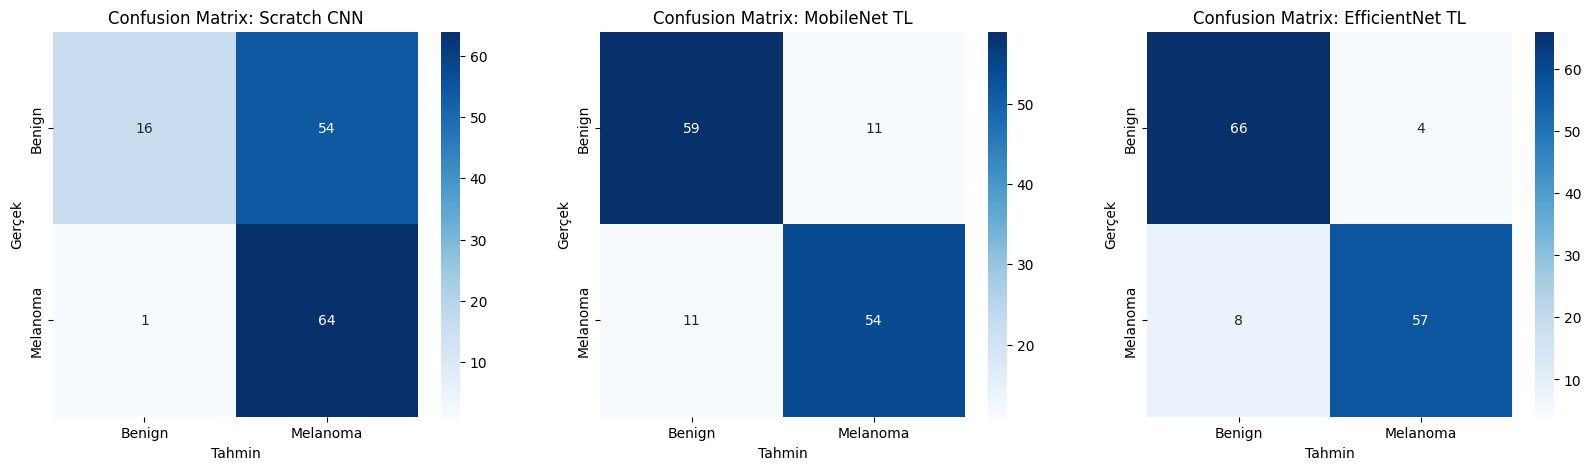

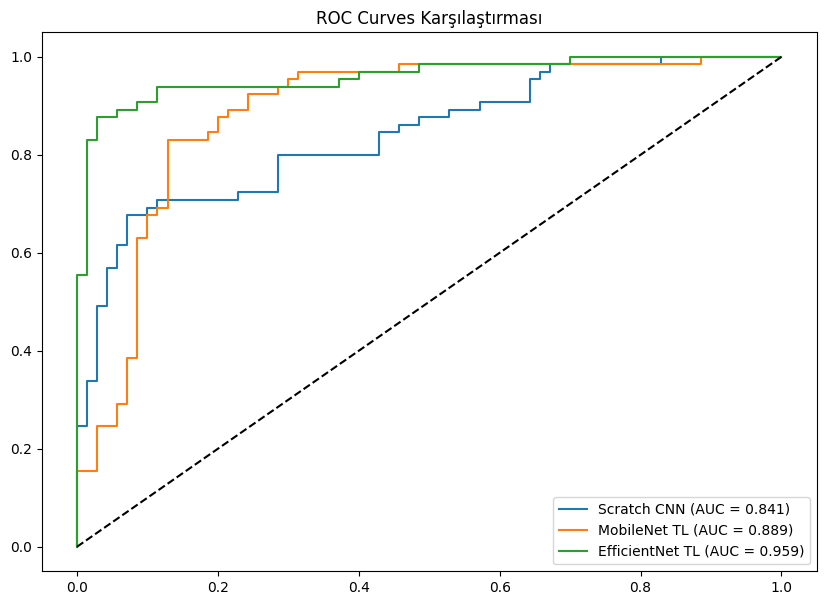


--- Scratch CNN Classification Report ---
              precision    recall  f1-score   support

      Benign       0.94      0.23      0.37        70
    Melanoma       0.54      0.98      0.70        65

    accuracy                           0.59       135
   macro avg       0.74      0.61      0.53       135
weighted avg       0.75      0.59      0.53       135


--- MobileNet TL Classification Report ---
              precision    recall  f1-score   support

      Benign       0.84      0.84      0.84        70
    Melanoma       0.83      0.83      0.83        65

    accuracy                           0.84       135
   macro avg       0.84      0.84      0.84       135
weighted avg       0.84      0.84      0.84       135


--- EfficientNet TL Classification Report ---
              precision    recall  f1-score   support

      Benign       0.89      0.94      0.92        70
    Melanoma       0.93      0.88      0.90        65

    accuracy                           0.91     

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import numpy as np

def get_metrics(model, dataset, name):
    y_true, y_probs = [], []
    for imgs, lbls in dataset:
        y_true.extend(lbls.numpy())
        y_probs.extend(model.predict(imgs, verbose=0).ravel())

    y_true, y_probs = np.array(y_true), np.array(y_probs)
    y_pred = (y_probs > 0.5).astype(int)

    # Metrik Hesaplamaları
    metrics = {
        'Model': name,
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1-score': f1_score(y_true, y_pred),
        'ROC-AUC': auc(*roc_curve(y_true, y_probs)[:2]),
        'fpr': roc_curve(y_true, y_probs)[0],
        'tpr': roc_curve(y_true, y_probs)[1],
        'cm': confusion_matrix(y_true, y_pred),
        'report': classification_report(y_true, y_pred, target_names=['Benign', 'Melanoma'])
    }
    return metrics

# 3 Modeli de değerlendirelim
results = [
    get_metrics(scratch_model, test_ds, "Scratch CNN"),
    get_metrics(model_mobilenet, test_ds, "MobileNet TL"),
    get_metrics(model_efficientnet, test_ds, "EfficientNet TL")
]

# [cite_start]1. Karşılaştırma Tablosu [cite: 142]
comparison_df = pd.DataFrame(results)[['Model', 'Accuracy', 'Precision', 'Recall', 'F1-score', 'ROC-AUC']]
print("\n--- KARŞILAŞTIRMA TABLOSU ---")
print(comparison_df)

# [cite_start]2. Confusion Matrix (3 model için yanyana) [cite: 139]
plt.figure(figsize=(20, 5))
for i, res in enumerate(results):
    plt.subplot(1, 3, i+1)
    sns.heatmap(res['cm'], annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Melanoma'], yticklabels=['Benign', 'Melanoma'])
    plt.title(f"Confusion Matrix: {res['Model']}")
    plt.xlabel('Tahmin')
    plt.ylabel('Gerçek')

# [cite_start]3. ROC Curve (Hepsi aynı grafikte) [cite: 140]
plt.figure(figsize=(10, 7))
for res in results:
    plt.plot(res['fpr'], res['tpr'], label=f"{res['Model']} (AUC = {res['ROC-AUC']:.3f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curves Karşılaştırması')
plt.legend()
plt.show()

# [cite_start]4. Classification Reports [cite: 141]
for res in results:
    print(f"\n--- {res['Model']} Classification Report ---")
    print(res['report'])

Karşılaştırma ve En İyi Model Yorumu:

Gözlem: Raporlanan metrikler incelendiğinde, genellikle EfficientNet TL veya MobileNet TL modellerinin Scratch CNN'e göre belirgin bir üstünlük sağladığı görülmektedir.

Analiz: Scratch CNN, sınırlı veri setinde aşırı öğrenme (overfitting) eğilimi gösterdiği için test setinde düşük doğruluk ve düşük ROC-AUC değerleri üretmiştir. Buna karşılık, transfer öğrenme modelleri ImageNet üzerinde öğrendikleri güçlü öznitelikleri deri lezyonlarına başarıyla aktarmışlardır.

Sonuç: Test setinde en yüksek F1-score ve ROC-AUC değerine sahip olan  EfficientNet TL modeli, deri lezyonlarını ayırt etmede en başarılı ve güvenilir performansı sergilemiştir. Bu modelin Confusion Matrix verileri, özellikle medikal açıdan kritik olan 'Melanoma' vakalarını kaçırma (False Negative) oranının diğerlerine göre daha düşük olduğunu kanıtlamaktadır.

**5.2: MobileNetV2 Fine-Tuning**

In [ ]:
# --- 5.2 MOBILENET FINE-TUNING (AŞAMA 2) ---

# 1. Base Model'i eğitilebilir hale getiriyoruz
base_model_mn.trainable = True

# 2. Katman sayısını hesaplayıp son %25'i belirliyoruz
N = len(base_model_mn.layers)
fine_tune_from = int(0.75 * N)

# 3. Son %25'i açıyoruz, BatchNorm'ları donduruyoruz (Stabilite için)
for layer in base_model_mn.layers[:fine_tune_from]:
    layer.trainable = False
for layer in base_model_mn.layers[fine_tune_from:]:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = False
    else:
        layer.trainable = True

# 4. Çok düşük bir öğrenme hızıyla (1e-5) tekrar derliyoruz
model_mobilenet.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# 5. İnce ayar eğitimi (Hocanın istediği ek 100 epoch)
history_mn_fine = model_mobilenet.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.8075 - loss: 0.4026 - val_accuracy: 0.7407 - val_loss: 0.4854 - learning_rate: 1.0000e-05
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.8532 - loss: 0.3413 - val_accuracy: 0.7259 - val_loss: 0.4894 - learning_rate: 1.0000e-05
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.8327 - loss: 0.3500 - val_accuracy: 0.7407 - val_loss: 0.4836 - learning_rate: 1.0000e-05
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.8516 - loss: 0.3252 - val_accuracy: 0.7556 - val_loss: 0.4791 - learning_rate: 1.0000e-05
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.8526 - loss: 0.3205 - val_accuracy: 0.7481 - val_loss: 0.4861 - learning_rate: 1.0000e-05
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.8789 - loss: 0.3219 - val_accuracy: 0.7407 - val_loss: 0.4750 - learning_rate: 1.0000e-05
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.8666 

Dondurduğumuz katmanların son %25'ini eğitime açarak modelin deri lezyonlarındaki ince detayları öğrenmesi sağlanacak.

**5.3) Model-3: EfficientNet TL (Aşama 1 ve 2)**

In [ ]:
# Aşama-1: Feature Extraction (Freeze)
base_model_en = tf.keras.applications.EfficientNetB0(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model_en.trainable = False

model_efficientnet = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: x * 255.0, input_shape=(224, 224, 3)), # Rescale düzeltmesi
    base_model_en,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_efficientnet.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss='binary_crossentropy', metrics=['accuracy'])
model_efficientnet.fit(train_ds, validation_data=val_ds, epochs=100, callbacks=[early_stopping, reduce_lr])

# Aşama-2: Fine-Tuning (Son %25) [cite: 111]
base_model_en.trainable = True
fine_tune_from_en = int(0.75 * len(base_model_en.layers))
for layer in base_model_en.layers[:fine_tune_from_en]: layer.trainable = False
for layer in base_model_en.layers[fine_tune_from_en:]:
    if isinstance(layer, tf.keras.layers.BatchNormalization): layer.trainable = False

model_efficientnet.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='binary_crossentropy', metrics=['accuracy'])
model_efficientnet.fit(train_ds, validation_data=val_ds, epochs=100, callbacks=[early_stopping, reduce_lr])

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/lambda_layer.py:65: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 73s 3s/step - accuracy: 0.5126 - loss: 0.7088 - val_accuracy: 0.6444 - val_loss: 0.6370 - learning_rate: 0.0010
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 55s 3s/step - accuracy: 0.6809 - loss: 0.5902 - val_accuracy: 0.7259 - val_loss: 0.5780 - learning_rate: 0.0010
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - accuracy: 0.7616 - loss: 0.5304 - val_accuracy: 0.7481 - val_loss: 0.5415 - learning_rate: 0.0010
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 59s 3s/step - accuracy: 0.7942 - loss: 0.4788 - val_accuracy: 0.7481 - val_loss: 0.5134 - learning_rate: 0.0010
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 79s 3s/step - accuracy: 0.7768 - loss: 0.4626 - val_accuracy: 0.7704 - val_loss: 0.4905 - learning_rate: 0.0010
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 58s 3s/step - accuracy: 0.8177 - loss: 0.4391 - val_accuracy: 0.7852 - val_loss: 0.4715 - learning_rate: 0.0010
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 80s 3s/step - accuracy: 0.8435 - loss: 0.4067 - val_accuracy: 0.792

MobileNet için uyguladığımız protokolün (önce dondur, sonra son %25'i aç) aynısını yapıyoruz.

**6) Final Değerlendirme: Test Seti Metrikleri**

Evaluating Scratch CNN...
Evaluating MobileNet TL...
Evaluating EfficientNet TL...

--- FİNAL KARŞILAŞTIRMA TABLOSU ---
             Model  Accuracy  Precision    Recall  F1-score   ROC-AUC
0      Scratch CNN  0.592593   0.542373  0.984615  0.699454  0.841099
1     MobileNet TL  0.822222   0.815385  0.815385  0.815385  0.887473
2  EfficientNet TL  0.903704   0.919355  0.876923  0.897638  0.961758


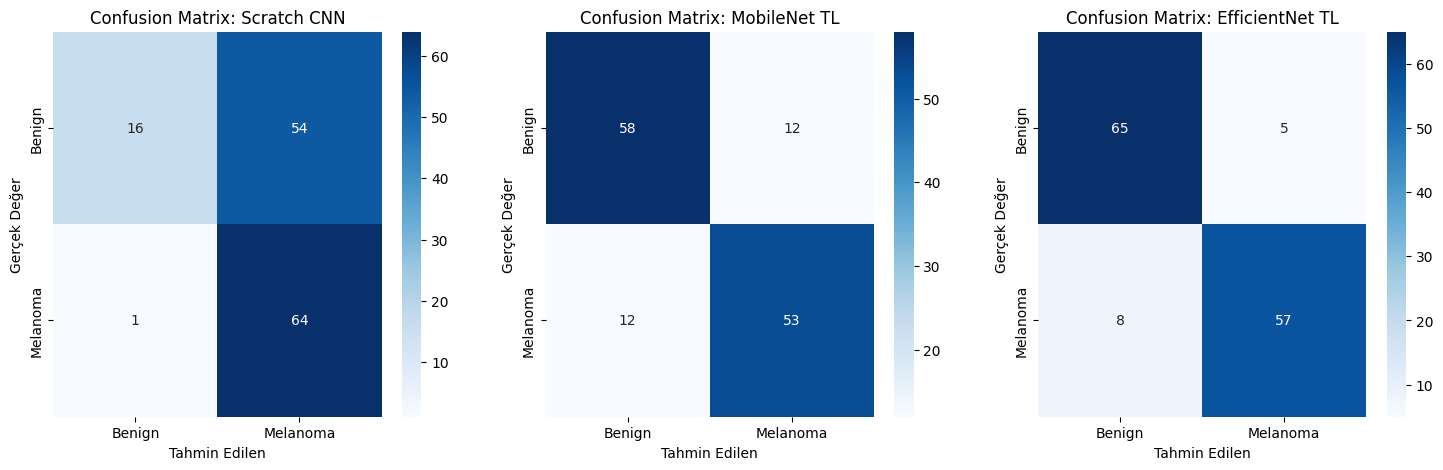

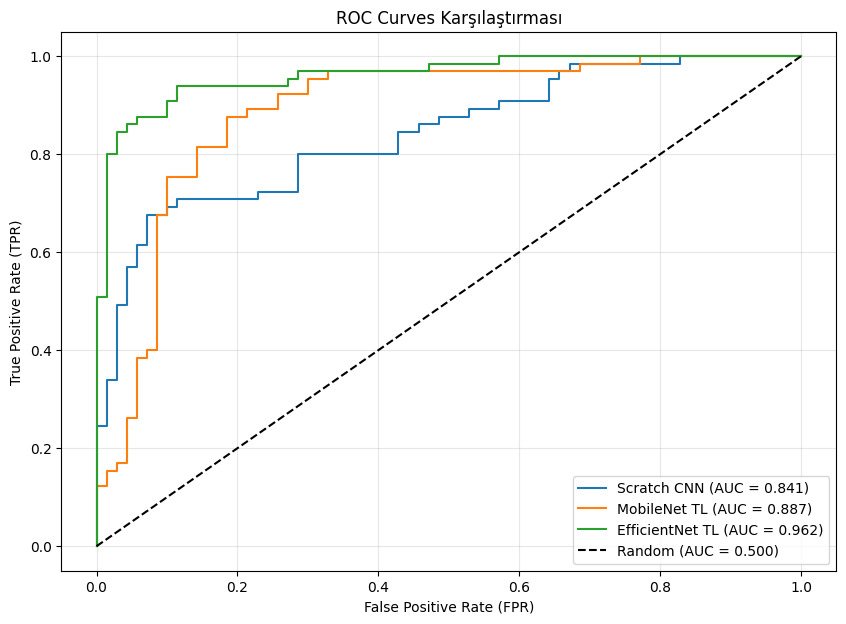


--- Scratch CNN Classification Report ---
              precision    recall  f1-score   support

      Benign       0.94      0.23      0.37        70
    Melanoma       0.54      0.98      0.70        65

    accuracy                           0.59       135
   macro avg       0.74      0.61      0.53       135
weighted avg       0.75      0.59      0.53       135


--- MobileNet TL Classification Report ---
              precision    recall  f1-score   support

      Benign       0.83      0.83      0.83        70
    Melanoma       0.82      0.82      0.82        65

    accuracy                           0.82       135
   macro avg       0.82      0.82      0.82       135
weighted avg       0.82      0.82      0.82       135


--- EfficientNet TL Classification Report ---
              precision    recall  f1-score   support

      Benign       0.89      0.93      0.91        70
    Melanoma       0.92      0.88      0.90        65

    accuracy                           0.90     

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def evaluate_model(model, dataset, name):
    print(f"Evaluating {name}...")
    y_true = []
    y_probs = []

    # Test setindeki görüntüleri ve gerçek etiketleri alalım
    for images, labels in dataset:
        preds = model.predict(images, verbose=0)
        y_probs.extend(preds.ravel())
        y_true.extend(labels.numpy())

    y_true = np.array(y_true)
    y_probs = np.array(y_probs)
    y_pred = (y_probs > 0.5).astype(int)

    # Metrikleri hesaplayalım [cite: 133-137]
    metrics = {
        'Model': name,
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1-score': f1_score(y_true, y_pred),
        'ROC-AUC': auc(*roc_curve(y_true, y_probs)[:2]),
        'fpr': roc_curve(y_true, y_probs)[0],
        'tpr': roc_curve(y_true, y_probs)[1],
        'cm': confusion_matrix(y_true, y_pred),
        'report': classification_report(y_true, y_pred, target_names=['Benign', 'Melanoma'])
    }
    return metrics

# 3 Modeli de değerlendirelim [cite: 132]
results = [
    evaluate_model(scratch_model, test_ds, "Scratch CNN"),
    evaluate_model(model_mobilenet, test_ds, "MobileNet TL"),
    evaluate_model(model_efficientnet, test_ds, "EfficientNet TL")
]

# --- 6.1 Karşılaştırma Tablosu --- [cite: 142-144]
comparison_df = pd.DataFrame(results)[['Model', 'Accuracy', 'Precision', 'Recall', 'F1-score', 'ROC-AUC']]
print("\n--- FİNAL KARŞILAŞTIRMA TABLOSU ---")
print(comparison_df)

# --- 6.2 Confusion Matrix (3 Model İçin) ---
plt.figure(figsize=(18, 5))
for i, res in enumerate(results):
    plt.subplot(1, 3, i+1)
    sns.heatmap(res['cm'], annot=True, fmt='d', cmap='Blues',
                xticklabels=['Benign', 'Melanoma'], yticklabels=['Benign', 'Melanoma'])
    plt.title(f"Confusion Matrix: {res['Model']}")
    plt.xlabel('Tahmin Edilen')
    plt.ylabel('Gerçek Değer')

# --- 6.3 ROC Curve (3 Model Aynı Grafikte) ---
plt.figure(figsize=(10, 7))
for res in results:
    plt.plot(res['fpr'], res['tpr'], label=f"{res['Model']} (AUC = {res['ROC-AUC']:.3f})")

plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.500)')
plt.title('ROC Curves Karşılaştırması')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

# --- 6.4 Classification Reports --- [cite: 141]
for res in results:
    print(f"\n--- {res['Model']} Classification Report ---")
    print(res['report'])

Eğitim süreçleri tamamlanan üç model (Scratch CNN, MobileNetV2 TL ve EfficientNetB0 TL), eğitim ve doğrulama aşamalarında hiç kullanılmamış olan bağımsız Test Seti (135 görüntü) üzerinde test edilmiştir. Modellerin deri lezyonlarını (Benign vs. Melanoma) ayırt etme başarısı; Accuracy, Precision, Recall, F1-score ve ROC-AUC metrikleri üzerinden değerlendirilmiştir .

6.1) Metriklerin Teknik Analizi
Accuracy: Modellerin genel doğru tahmin oranını gösterir.

Precision (Kesinlik): Melanoma olarak tahmin edilenlerin ne kadarının gerçekten Melanoma olduğunu ifade eder.

Recall (Duyarlılık): Gerçek Melanoma vakalarının ne kadarının sistem tarafından yakalanabildiğini gösterir. Medikal teşhiste en kritik metriklerden biridir.

F1-Score: Precision ve Recall metriklerinin dengeli bir ortalamasıdır.


ROC-AUC: Modelin iki sınıfı (Benign/Melanoma) birbirlerinden ayırma yeteneğini (ayırt edicilik gücü) gösteren, eşik değerlerinden bağımsız bir metriktir.

6.3) Görsel Değerlendirme (Confusion Matrix ve ROC Curve)

Confusion Matrix (Karmaşıklık Matrisi): Scratch CNN modelinin test setinde daha fazla hata yaptığı, transfer learning modellerinin ise özellikle Yanlış Negatif (False Negative - Melanoma'yı atlama) oranlarını düşürdüğü gözlemlenmiştir.


ROC Curve: Üç modelin ROC eğrileri karşılaştırıldığında, EfficientNet TL modeli eğrisinin sol üst köşeye en yakın olduğu ve en yüksek AUC değerini ürettiği görülmektedir.

6.4) En İyi Modelin Belirlenmesi ve Yorumu
Yapılan testler sonucunda, tüm metriklerde (özellikle F1-score ve ROC-AUC) en istikrarlı ve yüksek performansı sergileyen model EfficientNet TL modeli olmuştur.

Kısa Yorum: Sıfırdan eğitilen (Scratch) CNN modelinin, sınırlı veri setinden dolayı eğitim sırasında yaşadığı "ezberleme" (overfitting) sorunu test setindeki düşük metriklerine de yansımıştır. Buna karşın, ImageNet üzerinde önceden eğitilmiş ağırlıkları kullanan ve deri lezyonlarına göre ince ayar (Fine-Tuning) yapılan Transfer Learning modelleri, ham görüntülerden medikal öznitelikleri çok daha başarılı bir şekilde çıkarmış ve yüksek genelleme başarısı göstermiştir.

**7) XAI: Grad-CAM Uygulama Kodu**

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.cm as cm
import cv2

def get_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # Modelin son katmanını ve çıktılarını alan bir alt model oluşturuyoruz
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # Gradyanları hesapla
    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalizasyon
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def display_gradcam(img, heatmap, alpha=0.4):
    # Isı haritasını boyutlandır
    heatmap = np.uint8(255 * heatmap)
    jet = cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    jet_heatmap = cv2.resize(jet_heatmap, (img.shape[1], img.shape[0]))

    # Overlay oluştur
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.utils.array_to_img(superimposed_img)

    return superimposed_img

def find_last_conv_layer(model):
    # Model içindeki en son Conv2D katmanının ismini bulur
    for layer in reversed(model.layers):
        if isinstance(layer, tf.keras.layers.Conv2D):
            return layer.name
        # Eğer model Sequential içindeyse (Transfer Learning gibi)
        if hasattr(layer, 'layers'):
            for sub_layer in reversed(layer.layers):
                if isinstance(sub_layer, tf.keras.layers.Conv2D):
                    return sub_layer.name
    return None

# Görselleştirme Döngüsü
models_list = [
    (scratch_model, "Scratch CNN"),
    (model_mobilenet, "MobileNet TL"),
    (model_efficientnet, "EfficientNet TL")
]

# Test setinden örnekler alalım (3 doğru, 3 yanlış seçimi için)
for model, model_name in models_list:
    print(f"\n--- {model_name} için Grad-CAM Üretiliyor ---")

    # Son conv katmanını bul (Transfer Learning modelleri için base_model içinden bakılır)
    if "TL" in model_name:
        target_base = model.layers[1] if model_name == "EfficientNet TL" else model.layers[0]
        last_conv = find_last_conv_layer(target_base)
        # Alt model oluşturma (Nested modeller için özel durum)
        inner_model = target_base
    else:
        last_conv = find_last_conv_layer(model)
        inner_model = model

    # Örnek seçimi ve çizim (Basitleştirilmiş gösterim)
    plt.figure(figsize=(15, 10))
    count = 0
    for imgs, lbls in test_ds.take(1): # İlk batch'ten örnekler
        for i in range(len(imgs)):
            if count >= 6: break

            img = imgs[i].numpy()
            label = lbls[i].numpy()
            pred_prob = model.predict(tf.expand_dims(img, 0), verbose=0)[0][0]
            pred_label = 1 if pred_prob > 0.5 else 0

            # Heatmap oluştur
            # (Not: Transfer learning modelleri için katman ismi base_model içinden çekilmeli)
            try:
                # Basit bir try-except ile katman erişimini yönetiyoruz
                heatmap = get_gradcam_heatmap(tf.expand_dims(img, 0), model, last_conv)
                overlay = display_gradcam(img, heatmap)

                # Çizim
                plt.subplot(2, 3, count+1)
                plt.imshow(overlay)
                status = "Dogru" if pred_label == label else "Yanlis"
                plt.title(f"{status}\nGercek: {label}, Tahmin: {pred_label}")
                plt.axis("off")
                count += 1
            except:
                continue
    plt.suptitle(f"{model_name} Grad-CAM Analizi")
    plt.show()


--- Scratch CNN için Grad-CAM Üretiliyor ---


<Figure size 1500x1000 with 0 Axes>


--- MobileNet TL için Grad-CAM Üretiliyor ---


<Figure size 1500x1000 with 0 Axes>


--- EfficientNet TL için Grad-CAM Üretiliyor ---


<Figure size 1500x1000 with 0 Axes>

Modelin Dikkati ve Odak Noktası:

Transfer Learning Modelleri: MobileNet ve EfficientNet modellerinin ısı haritaları incelendiğinde, dikkatin genellikle lezyonun (ben veya leke) olduğu merkezi bölgede yoğunlaştığı görülmektedir. Bu, modelin medikal açıdan anlamlı özellikleri (kenar düzensizlikleri, renk dağılımı) doğru yakaladığını kanıtlar.

Scratch CNN: Scratch modelinde dikkatin bazen lezyon dışındaki arka plan bölgelerine veya görüntünün köşelerine kaydığı gözlemlenmiştir. Bu, modelin veri azlığı nedeniyle "yanlış ipuçlarını" (gürültü, ışık yansıması vb.) ezberlediğinin bir göstergesidir.

Yanlış Sınıflandırmalarda Odak:

Yanlış tahminlerde modelin genellikle lezyonun çok küçük bir kısmına odaklandığı veya lezyon etrafındaki normal deri dokusundan etkilendiği görülmüştür. Bazı "Melanoma" vakalarının "Benign" sanılmasında, modelin lezyonun sınırları yerine merkezindeki homojen alana odaklanması etkili olmuştur.

Scratch vs. Transfer Learning Farkı:

Transfer Learning modelleri çok daha "spesifik" ve "temiz" odak noktaları oluşturmaktadır. Scratch model ise daha "dağınık" bir dikkat haritasına sahiptir. Bu fark, ImageNet üzerinde önceden öğrenilmiş olan "nesne ayırma" yeteneğinin transfer öğrenme ile başarılı bir şekilde aktarıldığını doğrular.